##  Corrective RAG(Type of the Agentic RAG)

In this architecture we are correcting the information from any other data source if retriever is not able to generate a correct output (in this architecture the external data source is web search)

In [2]:
# %pip install langchain google_genai chroma chromadb bs4 tiktoken transformers

%pip install dotenv


   ---------------------------------------- 0/2 [python-dotenv]
   ---------------------------------------- 0/2 [python-dotenv]
   ---------------------------------------- 0/2 [python-dotenv]
   ---------------------------------------- 2/2 [dotenv]

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
%pip install langchain_google_genai

  Using cached langchain_google_genai-2.1.5-py3-none-any.whl.metadata (5.2 kB)
  Using cached filetype-1.2.0-py2.py3-none-any.whl.metadata (6.5 kB)
  Using cached google_ai_generativelanguage-0.6.18-py3-none-any.whl.metadata (9.8 kB)
  Using cached langchain_core-0.3.66-py3-none-any.whl.metadata (5.8 kB)
  Using cached pydantic-2.11.7-py3-none-any.whl.metadata (67 kB)
  Using cached google_api_core-2.25.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached google_auth-2.40.3-py2.py3-none-any.whl.metadata (6.2 kB)
  Using cached proto_plus-1.26.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached protobuf-6.31.1-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached googleapis_common_protos-1.70.0-py3-none-any.whl.metadata (9.3 kB)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached grpcio-1.73.0-cp313-cp313-win_amd64.whl.metadata (4.0 kB)
  Using cached grpcio_status-1.73.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached cachetools-5.5.2-py3-none-any.w

### Load the model

In [6]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-001")

In [7]:
result = llm.invoke("Write a joke about LangChain")
print(result.content)

Why did the LangChain agent get lost in the documentation?

Because it was trying to find the optimal route to answer a question, but ended up in a deep loop of self-referential PDFs! It kept saying, "I think I need to use this document to understand this document, which refers to this document..."  Eventually, it just gave up and said, "Maybe I should just ask a human."


### Create a Retriever now

In [17]:
%pip install langchain langchain_community bs4 tiktoken chromadb

  Using cached chromadb-1.0.13-cp39-abi3-win_amd64.whl.metadata (7.1 kB)
  Using cached build-1.2.2.post1-py3-none-any.whl.metadata (6.5 kB)
  Using cached pybase64-1.4.1-cp313-cp313-win_amd64.whl.metadata (8.7 kB)
  Using cached uvicorn-0.34.3-py3-none-any.whl.metadata (6.5 kB)
  Using cached posthog-5.4.0-py3-none-any.whl.metadata (5.7 kB)
  Using cached onnxruntime-1.22.0-cp313-cp313-win_amd64.whl.metadata (5.0 kB)
  Using cached opentelemetry_api-1.34.1-py3-none-any.whl.metadata (1.5 kB)
  Using cached opentelemetry_exporter_otlp_proto_grpc-1.34.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached opentelemetry_sdk-1.34.1-py3-none-any.whl.metadata (1.6 kB)
  Using cached pypika-0.48.9-py2.py3-none-any.whl
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached overrides-7.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached bcrypt-4.3.0-cp39-abi3-win_amd64.whl.metadata (10 kB)
  Using ca

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.73.0 requires protobuf<7.0.0,>=6.30.0, but you have protobuf 5.29.5 which is incompatible.


In [18]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
urls = [
    "https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_crag/"
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
print(f"Loaded {len(docs_list)} documents from {len(urls)} URLs.")

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)


# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)


retriever = vectorstore.as_retriever()


Loaded 1 documents from 1 URLs.


### Create a RAG Chain Now

In [19]:

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

print(f"---PROMPT--- {prompt}")

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

---PROMPT--- input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


### Test the RAG Chain Now

In [20]:
# Run
question = "tell me about Corrective rag."
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

Corrective RAG (CRAG) is a RAG strategy that uses self-reflection and self-grading on retrieved documents. It checks the relevance of documents, and if they don't meet a threshold, it seeks additional data via web search. CRAG can also refine knowledge by partitioning documents into strips, grading each strip, and filtering out irrelevant ones.


In [22]:
%pip install pydantic

Note: you may need to restart the kernel to use updated packages.


### Create Grade Documents class

In [23]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field


class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

In [24]:
# LLM with structured output
structured_llm_grader = llm.with_structured_output(GradeDocuments)
# Prompt
system = """You are a grader, assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [25]:
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

C:\Users\Nagamohan\AppData\Local\Temp\ipykernel_27836\2311755990.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


binary_score='yes'


In [26]:
question = "tell me about the Adaptive RAG"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='no'


### Create Question Re-Writer

In [27]:
### Question Re-writer
# Prompt
from langchain_core.prompts import ChatPromptTemplate

system = """You a question re-writer that converts an input question to a better version that is optimized  
     for web search. Look at the input and try to reason about the underlying semantic intent or meaning."""
     
     
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Generate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

In [28]:
rewritten_question=question_rewriter.invoke({"question": question})
print(f"Rewritten question: {rewritten_question}")

Rewritten question: Here are a few options for improved questions, depending on what aspect of "Adaptive RAG" you're most interested in:

*   **What is Adaptive RAG and how does it work?** (Broad, good starting point)
*   **How does Adaptive RAG improve traditional RAG systems?** (Focuses on the benefits)
*   **What are the different approaches to implementing Adaptive RAG?** (Focuses on implementation details)
*   **What are the benefits and challenges of using Adaptive RAG?** (Balanced perspective)
*   **Adaptive RAG vs. traditional RAG: a comparison** (Direct comparison)

I would recommend the first one, "What is Adaptive RAG and how does it work?" as a good starting point.


### Create a retrieve docs function

In [29]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
    
    """
    print("---RETRIEVE---")
    
    question = state["question"]
    
    documents = retriever.get_relevant_documents(question)
    
    return {"documents": documents, "question": question}

### Create Grade Documents 

In [30]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    
    print("---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---")
    
    question = state["question"]
    
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    
    web_search = "No"
    
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

In [31]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    
    print("---GENERATE---")
    
    question = state["question"]
    documents = state["documents"]
    
    generation = rag_chain.invoke({"context": documents, "question": question})
    
    return {"documents": documents, "question": question, "generation": generation}

### Create Transform query

In [32]:
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    print("---TRANSFORM QUERY---")
    
    question = state["question"]
    
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    
    print(f"Rewritten question: {better_question}")
    
    return {"documents": documents, "question": better_question}

### Web Crawling using Tavily

In [34]:
%pip install langchain_tavily

   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   --- ------------------------------------ 0.8/9.6 MB 5.3 MB/s eta 0:00:02
   -------- ------------------------------- 2.1/9.6 MB 5.9 MB/s eta 0:00:02
   ------------- -------------------------- 3.1/9.6 MB 5.4 MB/s eta 0:00:02
   ------------------- -------------------- 4.7/9.6 MB 5.9 MB/s eta 0:00:01
   ------------------------- -------------- 6.0/9.6 MB 6.0 MB/s eta 0:00:01
   ------------------------------ --------- 7.3/9.6 MB 6.1 MB/s eta 0:00:01
   ------------------------------------- -- 8.9/9.6 MB 6.2 MB/s eta 0:00:01
   ---------------------------------------- 9.6/9.6 MB 6.1 MB/s eta 0:00:00

   ---------------------------------------- 0/3 [pathspec]
   ------------- -------------------------- 1/3 [mypy]
   ------------- -------------------------- 1/3 [mypy]
   ------------- -------------------------- 1/3 [mypy]
   ------------- -------------------------- 1/3 [mypy]
   ------------- --------------------------

In [35]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

### Create Web Seacrh

In [36]:

from langchain.schema import Document
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")
    
    question = state["question"]
    
    documents = state["documents"]
    
    print(f"Web search for question: {question}")

    # Web search
    docs = web_search_tool.invoke({"query": question})
    
    # Handle both dict and str results 
    if len(docs) > 0 and isinstance(docs[0], dict) and "content" in docs[0]:
        web_results = "\n".join([d["content"] for d in docs])
    else:
        web_results = "\n".join([str(d) for d in docs])
        
    print(f"Web search results: {web_results}")
    
    web_results = Document(page_content=web_results)
    
    documents.append(web_results)

    return {"documents": documents, "question": question}

### Create Edge Function to Transform query or Generate

In [37]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [39]:
%pip install langgraph

  Using cached langgraph_checkpoint-2.1.0-py3-none-any.whl.metadata (4.2 kB)
  Using cached langgraph_prebuilt-0.2.2-py3-none-any.whl.metadata (4.5 kB)
  Using cached langgraph_sdk-0.1.70-py3-none-any.whl.metadata (1.5 kB)
  Using cached xxhash-3.5.0-cp313-cp313-win_amd64.whl.metadata (13 kB)
  Using cached ormsgpack-1.10.0-cp313-cp313-win_amd64.whl.metadata (44 kB)
Using cached langgraph_checkpoint-2.1.0-py3-none-any.whl (43 kB)
Using cached langgraph_prebuilt-0.2.2-py3-none-any.whl (23 kB)
Using cached langgraph_sdk-0.1.70-py3-none-any.whl (49 kB)
Using cached ormsgpack-1.10.0-cp313-cp313-win_amd64.whl (121 kB)
Using cached xxhash-3.5.0-cp313-cp313-win_amd64.whl (30 kB)

   ------ --------------------------------- 1/6 [ormsgpack]
   ------------- -------------------------- 2/6 [langgraph-sdk]
   ------------- -------------------------- 2/6 [langgraph-sdk]
   -------------------- ------------------- 3/6 [langgraph-checkpoint]
   -------------------- ------------------- 3/6 [langgraph-

### Create State & Graph workflow

In [40]:
from langgraph.graph import END, StateGraph, START

In [41]:
from typing import List

from typing_extensions import TypedDict

class State(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

workflow= StateGraph(State)

In [42]:
# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

In [43]:
# Build graph
workflow.add_edge(START, "retrieve")

workflow.add_edge("retrieve", "grade_documents")

workflow.add_conditional_edges("grade_documents", decide_to_generate, {"transform_query": "transform_query","generate": "generate",}),

workflow.add_edge("transform_query", "web_search_node")

workflow.add_edge("web_search_node", "generate")

workflow.add_edge("generate", END)

In [44]:
# Compile the Graph
app = workflow.compile()

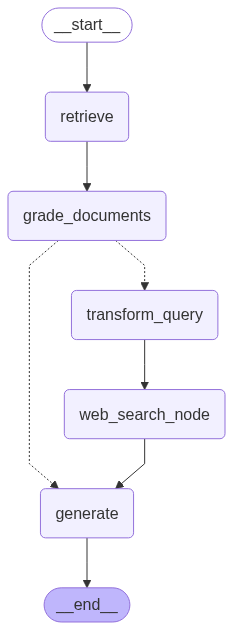

In [45]:
# Display the graph
from IPython.display import Image, display # type: ignore
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [46]:
from pprint import pprint

# Run
inputs = {"question": "tell me about Corrective RAG."}

In [47]:
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")
# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---
"Node 'retrieve':"
'\n---\n'
---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
Rewritten question: Here are a few options for improved questions, depending on the specific intent:

**Option 1 (Focus on explanation):**

*   "What is Corrective Retrieval Augmented Generation (RAG) and how does it work?"



In [48]:
from pprint import pprint

# Run
inputs = {"question": "tell me about Abdul Kalam."}

In [49]:
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")
# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---
"Node 'retrieve':"
'\n---\n'
---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
Rewritten question: "Who was Abdul Kalam and what were his major accomplishments?"
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
Web search for question: "Who was Abdul Kalam and what were his major acc